## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit
import csv

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import logging
import geopandas as gpd
import xarray as xr

import config
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)

# in case no memory
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

custom_working_dir = '../../../data/OGGM/'

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('rgi_id.v6', inplace=True)
rgi_df.head(2)

,short_name,full_name,sgi-id,rgi_id.v7,Issue
rgi_id.v6,,,,,
RGI60-11.02764,adler,Adler,B56/03,RGI2000-v7.0-G-11-01075,False
RGI60-11.02285,albigna,Albigna,NaN,RGI2000-v7.0-G-11-02309,True


In [4]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')
rgis = data_glamos.RGIId.unique()
all_gl = list(data_glamos.GLACIER.unique())
data_glamos.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy,snowslide_1m
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,0.340053,120.0,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618,1.0
1,2006,adler_55,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,0.219036,30.0,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481,1.0


In [5]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

glacier_list = list(data_glamos.GLACIER.unique())
glacier_list.sort()
glacier_list

['adler',
 'albigna',
 'aletsch',
 'allalin',
 'basodino',
 'claridenL',
 'claridenU',
 'corbassiere',
 'corvatsch',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'otemma',
 'pers',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'sanktanna',
 'schwarzbach',
 'schwarzberg',
 'sexrouge',
 'silvretta',
 'taelliboden',
 'tortin',
 'tsanfleuron']

## Testing with SGI:

In [6]:
def reformat_SGI_id(input_str):
    # Split the string by "/"
    part1, part2 = input_str.split("/")

    # Convert part1 to lowercase for the letter and retain the number
    part1 = part1[:-1] + part1[-1].lower()

    # Combine part1 and part2 with a hyphen in between
    return f"{part1}-{part2}"

In [7]:
def load_grid_file(filepath):
    with open(filepath, 'r') as file:
        # Read metadata
        metadata = {}
        for _ in range(6):  # First 6 lines are metadata
            line = file.readline().strip().split()
            metadata[line[0].lower()] = float(line[1])

        # Get ncols from metadata to control the number of columns
        ncols = int(metadata['ncols'])
        nrows = int(metadata['nrows'])
        print(f"ncols: {ncols}, nrows: {nrows}")

        # Initialize an empty list to store rows of the grid
        data = []

        # Read the grid data line by line
        row_ = []
        for line in file:
            row = line.strip().split()
            if len(row_) < ncols:
                row_ += row
            if len(row_) == ncols:
                data.append([
                    np.nan
                    if float(x) == metadata['nodata_value'] else float(x)
                    for x in row_
                ])
                # reset row_
                row_ = []

        # Convert list to numpy array
        grid_data = np.array(data)

        # Check that shape of grid data is correct
        print(grid_data.shape)
        assert grid_data.shape == (nrows, ncols)

    return metadata, grid_data

In [8]:
def convert_to_xarray(grid_data, metadata):
    # Extract metadata values
    ncols = int(metadata['ncols'])
    nrows = int(metadata['nrows'])
    xllcorner = metadata['xllcorner']
    yllcorner = metadata['yllcorner']
    cellsize = metadata['cellsize']

    # Create x and y coordinates based on the metadata
    x_coords = xllcorner + np.arange(ncols) * cellsize
    y_coords = yllcorner + np.arange(nrows) * cellsize

    # Create the xarray DataArray
    data_array = xr.DataArray(
        np.flip(grid_data, axis=0),
        #grid_data,
        dims=("y", "x"),
        coords={
            "y": y_coords,
            "x": x_coords
        },
        name="grid_data")
    return data_array

In [9]:
def xyzn_to_dataframe(xyzn_filename):
    """
    Reads a .xyzn file and converts it into a pandas DataFrame with columns x_pos, y_pos, and z_pos.

    Parameters:
    - xyzn_filename: Path to the .xyzn file.

    Returns:
    - A pandas DataFrame containing x, y, and z positions.
    """
    # Step 1: Read the .xyzn file and extract X, Y, Z positions
    data = []
    with open(xyzn_filename, 'r') as file:
        for line in file:
            # Split each line by space and extract the first three values (X, Y, Z)
            values = list(map(float, line.split()))
            x, y, z = values[0], values[1], values[2]
            data.append([x, y, z])  # Store X, Y, and Z

    # Step 2: Convert the list to a pandas DataFrame with columns x_pos, y_pos, z_pos
    df = pd.DataFrame(data, columns=['x_pos', 'y_pos', 'z_pos'])

    return df


def transform_xarray_coords_lv95_to_wgs84(data_array):
    # Flatten the DataArray (values) and extract x and y coordinates for each time step
    flattened_values = data_array.values.reshape(
        -1)  # Flatten entire 2D array (y, x)

    # flattened_values = data_array.values.flatten()
    y_coords, x_coords = np.meshgrid(data_array.y.values,
                                     data_array.x.values,
                                     indexing='ij')

    # Flatten the coordinate arrays
    flattened_x = x_coords.flatten()  # Repeat for each time step
    flattened_y = y_coords.flatten()  # Repeat for each time step

    # Create a DataFrame with columns for x, y, and value
    df = pd.DataFrame({
        'x_pos': flattened_x,
        'y_pos': flattened_y,
        'value': flattened_values
    })
    df['z_pos'] = 0

    # Convert to lat/lon
    #df = LV03toWGS84(df)
    df = LV95toWGS84(df)

    # Transform LV95 to WGS84 (lat, lon)
    lon, lat = df.lon.values, df.lat.values

    # Reshape the flattened WGS84 coordinates back to the original grid shape (time, y, x)
    lon = lon.reshape(x_coords.shape)  # Shape: (y, x)
    lat = lat.reshape(y_coords.shape)  # Shape: (y, x)

    # Assign the 1D WGS84 coordinates for swapping
    lon_1d = lon[0, :]  # take x (lon) values
    lat_1d = lat[:, 0]  # take y (lat) values

    # Assign the WGS84 coordinates back to the xarray
    data_array = data_array.assign_coords(lon=("x",
                                               lon_1d))  # Assign longitudes
    data_array = data_array.assign_coords(lat=("y",
                                               lat_1d))  # Assign latitudes

    # First, swap 'x' with 'lon' and 'y' with 'lat'
    data_array = data_array.swap_dims({'x': 'lon', 'y': 'lat'})

    # Reorder the dimensions to be (lon, lat)
    data_array = data_array.transpose("lon", "lat")

    return data_array


def LV03toWGS84(df):
    """Converts from swiss data coordinate system to lat/lon/height
    Args:
        df (pd.DataFrame): data in x/y swiss coordinates
    Returns:
        pd.DataFrame: data in lat/lon/coords
    """
    converter = GPSConverter()
    lat, lon, height = converter.LV03toWGS84(df['x_pos'], df['y_pos'],
                                             df['z_pos'])
    df['lat'] = lat
    df['lon'] = lon
    df['height'] = height
    df.drop(['x_pos', 'y_pos', 'z_pos'], axis=1, inplace=True)
    return df


def LV95toWGS84(df):
    """Converts from swiss data coordinate system to lat/lon/height
    Args:
        df (pd.DataFrame): data in x/y swiss coordinates
    Returns:
        pd.DataFrame: data in lat/lon/coords
    """
    transformer = Transformer.from_crs("EPSG:2056",
                                       "EPSG:4326",
                                       always_xy=True)

    # Sample CH1903+ / LV95 coordinates (Easting and Northing)

    # Transform to Latitude and Longitude (WGS84)
    lon, latitude = transformer.transform(df.x_pos, df.y_pos)

    df['lat'] = latitude
    df['lon'] = lon
    df.drop(['x_pos', 'y_pos', 'z_pos'], axis=1, inplace=True)
    return df


In [10]:
def draw_glacier_outline(xarray_data, xyzn_filename):
    """
    Add a glacier outline binary mask to an existing xarray. The glacier coordinates 
    might not perfectly align with the xarray grid, but the closest grid points will be used.

    Parameters:
    - xarray_data: The existing xarray with 'x' and 'y' coordinates.
    - xyzn_filename: The .xyzn file containing the glacier outline coordinates.

    Returns:
    - Updated xarray with a new variable `glacier_outline`.
    """
    # Step 1: Read the glacier coordinates from the .xyzn file
    df = xyzn_to_dataframe(xyzn_filename)  # This function must read the file and return a DataFrame
    if not all(col in df.columns for col in ['x_pos', 'y_pos']):
        raise ValueError("The dataframe must contain 'X' and 'Y' columns.")

    # Step 2: Extract the grid's x and y coordinates from the existing xarray
    x_coords = xarray_data.coords['x'].values
    y_coords = xarray_data.coords['y'].values

    # Step 3: Initialize the glacier outline mask with zeros (matching shape y, x)
    glacier_mask = np.zeros((len(y_coords), len(x_coords)), dtype=int)

    # Step 4: Loop through glacier coordinates and map to closest grid points
    for _, row in df.iterrows():
        gx, gy = row['x_pos'], row['y_pos']

        # Find the closest grid point (using absolute difference)
        closest_x_idx = (np.abs(x_coords - gx)).argmin()
        closest_y_idx = (np.abs(y_coords - gy)).argmin()

        # Update the glacier mask
        glacier_mask[closest_y_idx, closest_x_idx] = 1  # Note: y index first, then x index

    # Step 5: Create an xarray DataArray for the glacier outline mask
    glacier_outline = xr.DataArray(
        glacier_mask,
        coords={"y": y_coords, "x": x_coords},
        dims=["y", "x"],
        name="glacier_outline"
    )

    return glacier_outline

In [11]:
gl = 'rhone'
sgi_id = rgi_df[rgi_df.short_name == gl]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == gl].index[0]
sgi_id_ref = reformat_SGI_id(sgi_id)

# open a grid file
path_aspect = path_SGI_topo + 'aspect/'
path_slope = path_SGI_topo + 'slope/'
path_DEM = path_SGI_topo + 'dem_HR/'
path_outline = path_SGI_topo + 'outline/lv95/'

aspect_gl = [f for f in os.listdir(path_aspect) if sgi_id_ref in f][0]
slope_gl = [f for f in os.listdir(path_slope) if sgi_id_ref in f][0]
dem_gl = [f for f in os.listdir(path_DEM) if sgi_id_ref in f][0]
outline_gl = [f for f in os.listdir(path_outline) if sgi_id_ref in f][0]

metadata_aspect, grid_data_aspect = load_grid_file(path_aspect + aspect_gl)
metadata_slope, grid_data_slope = load_grid_file(path_slope + slope_gl)
metadata_dem, grid_data_dem = load_grid_file(path_DEM + dem_gl)

# convert to xarray
aspect = convert_to_xarray(grid_data_aspect, metadata_aspect)
slope = convert_to_xarray(grid_data_slope, metadata_slope)
dem = convert_to_xarray(grid_data_dem, metadata_dem)

# Add glacier outline to the xarray
glacier_outline = draw_glacier_outline(aspect, path_outline + outline_gl)

dataset = xr.Dataset({"aspect": aspect, "slope": slope, "dem": dem, "glacier_outline": glacier_outline})

# Transform the coordinates to WGS84
aspect_wgs84 = transform_xarray_coords_lv95_to_wgs84(aspect).transpose()
slope_wgs84 = transform_xarray_coords_lv95_to_wgs84(slope).transpose()
dem_wgs84 = transform_xarray_coords_lv95_to_wgs84(dem).transpose()
glacier_outline_wgs84 = transform_xarray_coords_lv95_to_wgs84(glacier_outline).transpose()

# Combine into a Dataset
dataset_wgs84 = xr.Dataset({"aspect": aspect_wgs84, "slope": slope_wgs84, "dem": dem_wgs84, "glacier_outline": glacier_outline_wgs84})

gl_coordinates = xyzn_to_dataframe(path_outline + outline_gl)

# Transform gl_coordinates to WGS84
gl_coordinates_wgs84 = LV95toWGS84(gl_coordinates)

ncols: 385, nrows: 844
(844, 385)
ncols: 385, nrows: 844
(844, 385)
ncols: 385, nrows: 844
(844, 385)


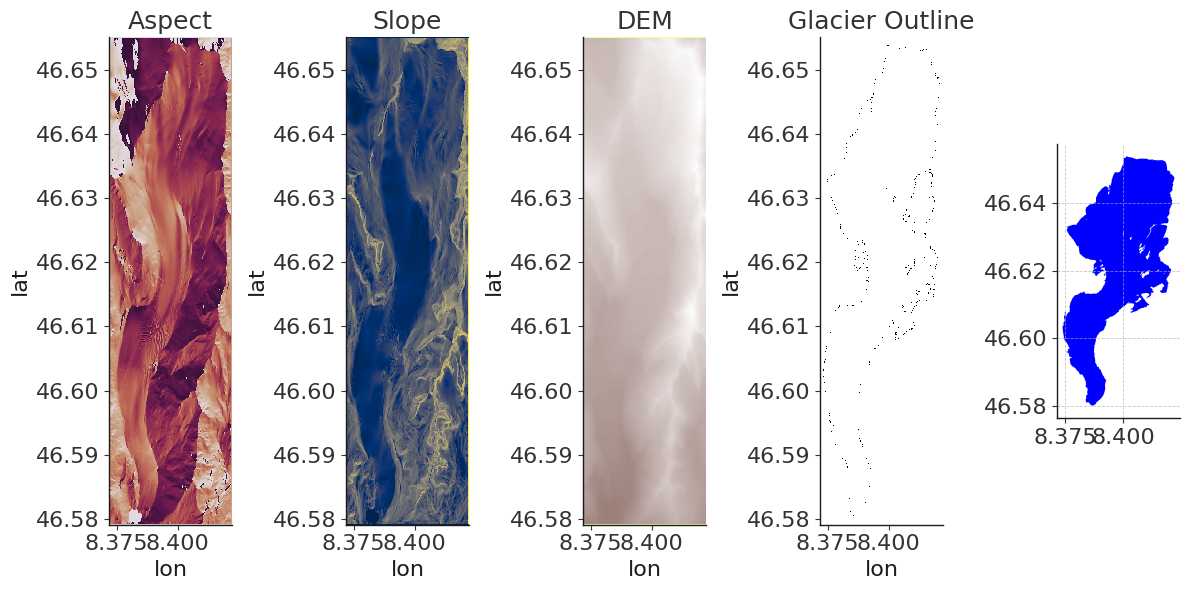

In [12]:
# plot aspect and slope, and dem
fig, axs = plt.subplots(1, 5, figsize=(12, 6))
dataset_wgs84.aspect.plot(x = 'lon', y = 'lat', ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
dataset_wgs84.slope.plot(x = 'lon', y = 'lat', ax=axs[1], cmap='cividis', add_colorbar=False)
dataset_wgs84.dem.plot(x = 'lon', y = 'lat', ax=axs[2], cmap='terrain', add_colorbar=False)
dataset_wgs84.glacier_outline.plot(x = 'lon', y = 'lat', ax=axs[3], cmap='binary', add_colorbar=False)

# Load the shapefile
shapefile_path = "../../../data/GLAMOS/topo/SGI_2016_glaciers_copy.shp"
gdf = gpd.read_file(shapefile_path)
gdf_gl = gdf[gdf.Name == 'Rhonegletscher']
gdf_gl.plot(ax = axs[4], color='blue')

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier Outline")
plt.tight_layout()

In [13]:
def xarray_to_geodataframe(xarray_data, var_name, crs=None):
    """
    Converts an xarray.DataArray into a GeoPandas GeoDataFrame with point geometries.

    Parameters:
    - xarray_data: xarray.DataArray or xarray.Dataset
    - var_name: Name of the variable to include in the GeoDataFrame.
    - crs: Coordinate Reference System (e.g., "EPSG:4326") for the GeoDataFrame.

    Returns:
    - GeoPandas GeoDataFrame with x, y coordinates and the variable values.
    """
    # Ensure xarray_data is a DataArray
    if isinstance(xarray_data, xr.Dataset):
        data_array = xarray_data[var_name]
    elif isinstance(xarray_data, xr.DataArray):
        data_array = xarray_data
    else:
        raise ValueError("Input must be an xarray.DataArray or xarray.Dataset.")

    # Flatten the DataArray into a 1D array
    flat_values = data_array.values.flatten()
    x_coords, y_coords = data_array.coords['x'].values, data_array.coords['y'].values

    # Create a meshgrid of x and y coordinates
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)

    # Flatten the coordinate grids
    flat_x = grid_x.flatten()
    flat_y = grid_y.flatten()

    # Create geometries (Point objects) for the GeoDataFrame
    geometries = [Point(x, y) for x, y in zip(flat_x, flat_y)]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        {"value": flat_values},  # Add variable values as a column
        geometry=geometries,     # Add geometries
        crs=crs                  # Set CRS if provided
    )

    return gdf

In [16]:
gdf = xarray_to_geodataframe(dataset_wgs84, 'aspect')
gdf

,value,geometry
0,-1.0,POINT (2671540 1159080)
1,-1.0,POINT (2671550 1159080)
2,-1.0,POINT (2671560 1159080)
3,-1.0,POINT (2671570 1159080)
4,-1.0,POINT (2671580 1159080)
...,...,...
324935,-1.0,POINT (2675340 1167510)
324936,-1.0,POINT (2675350 1167510)
324937,-1.0,POINT (2675360 1167510)
324938,-1.0,POINT (2675370 1167510)


In [14]:
import rasterio.features
from rasterio.transform import from_bounds

def extract_aspect_over_polygon(aspect_xarray, glacier_polygon_gdf):
    """
    Extracts aspect values over a glacier outline (polygon) from an xarray in WGS84 coordinates.

    Parameters:
    - aspect_xarray: xarray.DataArray containing the aspect values, with WGS84 coordinates.
    - glacier_polygon_gdf: GeoPandas GeoDataFrame with the glacier outline polygon (WGS84 CRS).

    Returns:
    - A masked xarray.DataArray with aspect values only within the glacier polygon.
    """
    # Ensure the GeoDataFrame is in WGS84 CRS
    if glacier_polygon_gdf.crs is None:
        raise ValueError("Glacier GeoDataFrame must have a defined CRS.")
    if glacier_polygon_gdf.crs.to_epsg() != 4326:
        glacier_polygon_gdf = glacier_polygon_gdf.to_crs("EPSG:4326")

    # # Ensure the xarray coordinates are in WGS84 CRS
    # if "spatial_ref" in aspect_xarray.coords:
    #     if "crs_wkt" in aspect_xarray.coords["spatial_ref"].attrs:
    #         xarray_crs = aspect_xarray.coords["spatial_ref"].attrs["crs_wkt"]
    #         if "EPSG:4326" not in xarray_crs:
    #             raise ValueError("Aspect xarray is not in WGS84 (EPSG:4326) coordinates.")
    # else:
    #     raise ValueError("Aspect xarray does not have CRS information.")

    # Get the x and y coordinates from the xarray
    x_coords = aspect_xarray.coords['x'].values
    y_coords = aspect_xarray.coords['y'].values

    # Compute the transform using rasterio's from_bounds
    transform = from_bounds(
        x_coords.min(), y_coords.min(), x_coords.max(), y_coords.max(),
        width=len(x_coords), height=len(y_coords)
    )

    # Rasterize the glacier polygon
    shapes = [(geom, 1) for geom in glacier_polygon_gdf.geometry]
    mask = rasterio.features.rasterize(
        shapes,
        out_shape=(len(y_coords), len(x_coords)),  # height (rows), width (cols)
        transform=transform,
        fill=0,
        dtype="int32"
    )

    # Apply the mask to the xarray
    masked_aspect = aspect_xarray.where(mask == 1)

    return masked_aspect

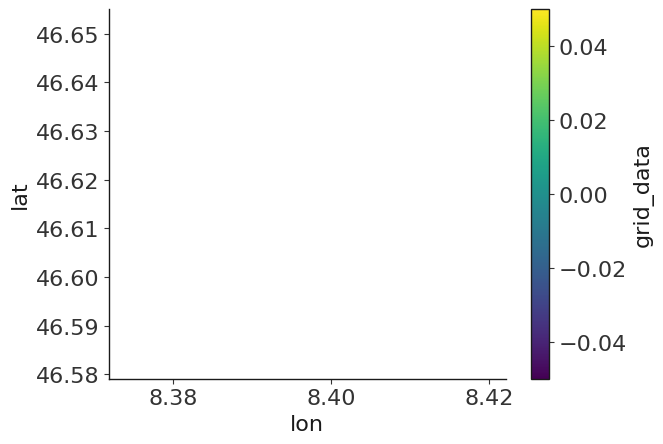

In [15]:
masked_aspect = extract_aspect_over_polygon(aspect_wgs84, gdf_gl)
masked_aspect.plot()

In [ ]:
gdf_gl

In [ ]:
glacierName = 'rhone'

rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]

# Load stake data for that glacier
data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
dataset_gl = mbm.Dataset(data=data_gl,
                         region_name='CH',
                         data_path=path_PMB_GLAMOS_csv)

ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(custom_working_dir)
# Plot glacier attributes of oggm:
plotGlAttr(ds, cmap=cm.devon)

In [ ]:
gdir.grid.proj

In [ ]:
def fill_glacier_outline(xarray_data, outline_var_name="glacier_outline"):
    """
    Fills the outline of a glacier in an xarray dataset to create a binary mask.

    Parameters:
    - xarray_data: xarray.Dataset containing the glacier outline variable.
    - outline_var_name: Name of the variable containing the glacier outline.

    Returns:
    - Updated xarray dataset with the filled glacier mask.
    """
    # Extract the glacier outline variable
    outline = xarray_data[outline_var_name].values
    x_coords = xarray_data.coords['x'].values
    y_coords = xarray_data.coords['y'].values

    # Find all points where the outline is 1
    outline_indices = np.argwhere(outline == 1)

    # Convert these indices to actual coordinates
    outline_points = [(x_coords[j], y_coords[i]) for i, j in outline_indices]

    # Create a polygon from the outline points
    polygon = Polygon(outline_points)

    # Create a grid of all points in the xarray
    grid_x, grid_y = np.meshgrid(x_coords, y_coords, indexing="xy")
    grid_points = np.array([grid_x.ravel(), grid_y.ravel()]).T

    # Create a binary mask by checking if points are inside the polygon
    mask = np.array([polygon.contains(Point(p))
                     for p in grid_points]).reshape(grid_x.shape)

    # Add the filled mask as a new variable in the dataset
    filled_mask = xr.DataArray(mask.astype(int),
                               coords={
                                   "y": y_coords,
                                   "x": x_coords
                               },
                               dims=["y", "x"],
                               name="glacier_filled_mask")

    # Add to the dataset
    xarray_data["glacier_filled_mask"] = filled_mask

    return xarray_data

In [ ]:
# Extract the glacier outline variable
outline = dataset['glacier_outline'].values
x_coords = dataset.coords['x'].values
y_coords = dataset.coords['y'].values

# Find all points where the outline is 1
outline_indices = np.argwhere(outline == 1)

# Convert these indices to actual coordinates
outline_points = [(x_coords[j], y_coords[i]) for i, j in outline_indices]

# Create a polygon from the outline points
polygon = Polygon(outline_points)

# plot polygon
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(*polygon.exterior.xy)

In [ ]:
fill_glacier_outline(dataset, outline_var_name="glacier_outline")

## Compute grids for all glaciers:

In [ ]:
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
voi_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
    "topo",
]

#### Test glaciers:

In [ ]:
RUN = False
# Add climate variables and convert to monthly
if RUN:
    emptyfolder(path_glacier_grid)
    # Glaciers used for testing
    rest_gl = [
        'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
        'joeri', 'corvatsch', 'tsanfleuron'
    ]
    for glacierName in tqdm(rest_gl, desc='Processing glaciers'):
        print('\n-----------------------------------')
        print(glacierName)
        rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]
        if glacierName == 'morteratsch' or glacierName == 'pers':
            rgi_gl = 'RGI60-11.01946'

        # check that rgi_gl is a str
        if type(rgi_gl) != str:
            raise ValueError('RGIId is not a string')

        # Load stake data for that glacier
        data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
        dataset_gl = mbm.Dataset(data=data_gl,
                                 region_name='CH',
                                 data_path=path_PMB_GLAMOS_csv)

        # Get gridded glacier data from OGGM
        df_grid = dataset_gl.create_glacier_grid(custom_working_dir)

        # Add metadata that is not in WGMS dataset
        df_grid["PERIOD"] = "annual"
        df_grid['GLACIER'] = glacierName

        dataset_grid = mbm.Dataset(data=df_grid,
                                   region_name='CH',
                                   data_path=path_PMB_GLAMOS_csv)
        # Add climate data:
        era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
        geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
        dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                          geopotential_data=geopotential_data,
                                          change_units=True)

        # Add potential clear sky radiation:
        print('Adding potential clear sky radiation')
        dataset_grid.get_potential_rad(path_direct_save)

        # For each record, convert to a monthly time resolution
        print('Converting to monthly time resolution')
        dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                        vois_climate=vois_climate + ['pcsr'],
                                        vois_topographical=voi_topographical)
        assert ('pcsr' in dataset_grid.data.columns)

        # Save gridded dataset:
        print('Saving gridded dataset')
        dataset_grid.data.to_csv(path_glacier_grid + f'{glacierName}_grid.csv',
                                 index=False)

#### Rest:

In [ ]:
EMPTY = False
if EMPTY:
    emptyfolder(path_glacier_grid)
    rest_rgis = rgis
    rest_gl = glacier_list
else:
    already_processed = [
        re.split('_', file)[0] for file in os.listdir(path_glacier_grid)
    ]
    already_processed_rgis = [
        rgi_df[rgi_df.short_name == gl].index.values[0]
        for gl in already_processed
    ]
    rest_rgis = Diff(already_processed_rgis, rgis)
    rest_gl = Diff(glacier_list, already_processed)
    print(rest_gl)

for glacierName in tqdm(rest_gl, desc='Processing glaciers'):
    print('\n-----------------------------------')
    print(glacierName)
    rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]
    if glacierName == 'morteratsch' or glacierName == 'pers':
        rgi_gl = 'RGI60-11.01946'

    # check that rgi_gl is a str
    if type(rgi_gl) != str:
        raise ValueError('RGIId is not a string')

    # Load stake data for that glacier
    data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
    dataset_gl = mbm.Dataset(data=data_gl,
                             region_name='CH',
                             data_path=path_PMB_GLAMOS_csv)

    # Get gridded glacier data from OGGM
    df_grid = dataset_gl.create_glacier_grid(custom_working_dir)

    # Add metadata that is not in WGMS dataset
    df_grid["PERIOD"] = "annual"
    df_grid['GLACIER'] = glacierName

    dataset_grid = mbm.Dataset(data=df_grid,
                               region_name='CH',
                               data_path=path_PMB_GLAMOS_csv)
    # Add climate data:
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
    dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                      geopotential_data=geopotential_data,
                                      change_units=True)

    # Add potential clear sky radiation:
    print('Adding potential clear sky radiation')
    dataset_grid.get_potential_rad(path_direct_save)

    # For each record, convert to a monthly time resolution
    print('Converting to monthly time resolution')
    dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                    vois_climate=vois_climate + ['pcsr'],
                                    vois_topographical=voi_topographical)
    assert ('pcsr' in dataset_grid.data.columns)

    # Save gridded dataset:
    print('Saving gridded dataset')
    dataset_grid.data.to_csv(path_glacier_grid + f'{glacierName}_grid.csv',
                             index=False)

## Check grids:

In [ ]:
glacierName = 'rhone'

rgi_gl = rgi_df[rgi_df.short_name == glacierName].index.values[0]

# Load stake data for that glacier
data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
dataset_gl = mbm.Dataset(data=data_gl,
                         region_name='CH',
                         data_path=path_PMB_GLAMOS_csv)

ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(custom_working_dir)
# Plot glacier attributes of oggm:
plotGlAttr(ds, cmap=cm.devon)